In [2]:
from keras.models import Sequential, load_model
from keras.layers import Dense, Embedding, LSTM, Bidirectional
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [1]:
import urllib.request

urllib.request.urlretrieve("https://raw.githubusercontent.com/bab2min/corpus/master/sentiment/steam.txt", filename="steam.txt")

('steam.txt', <http.client.HTTPMessage at 0x1fc539e4110>)

In [5]:
import pandas as pd

data = pd.read_table('steam.txt', names=['label','reviews'])
print('전체 리뷰 개수 :',len(data))

전체 리뷰 개수 : 100000


In [10]:
data[:5]

,label,reviews
0,0,노래가 너무 적음
1,0,"돌겠네 진짜. 황숙아, 어크 공장 그만 돌려라. 죽는다."
2,1,막노동 체험판 막노동 하는사람인데 장비를 내가 사야돼 뭐지
3,1,차악!차악!!차악!!! 정말 이래서 왕국을 되찾을 수 있는거야??
4,1,시간 때우기에 좋음.. 도전과제는 50시간이면 다 깰 수 있어요


In [12]:
data['reviews'].nunique(),data['label'].nunique()

(99892, 2)

In [13]:
data.drop_duplicates(subset=['reviews'],inplace=True)
print('총 샘플 수 :',len(data))

총 샘플 수 : 99892




---

## 📊 예제 데이터프레임

| reviews | rating |
| ------- | ------ |
| 좋아요     | 5      |
| 나빠요     | 2      |
| 좋아요     | 5 ← 중복 |
| 최고!     | 5      |

## 🔧 `inplace` 매개변수란?

* **설명**: `inplace` 매개변수는 **원본 데이터를 직접 수정할지 여부**를 결정하는 옵션입니다.
* **동작**

  * `inplace=True`: 원본 객체를 **직접 수정**, **반환값은 `None`**
  * `inplace=False` (기본값): **수정된 사본을 반환**, 원본은 그대로 유지됨

---




In [15]:
data.isnull().values.any()

False

---

## ✅ null 여부 확인

| A     | B     | C     |
| ----- | ----- | ----- |
| False | False | False |
| False | True  | False |
| True  | False | False |
| False | False | True  |

→ 각 셀이 null인지 True/False로 반환

```
[[False False False]  
 [False  True False]  
 [ True False False]  
 [False False  True]]  
```

→ DataFrame을 NumPy 배열로 변환

```
True
```

→ 배열에 True가 하나라도 있으면 True 반환

---


In [17]:
from sklearn.model_selection import train_test_split
train_data,test_data = train_test_split(data,test_size=0.25,random_state=42)

<Axes: xlabel='label'>

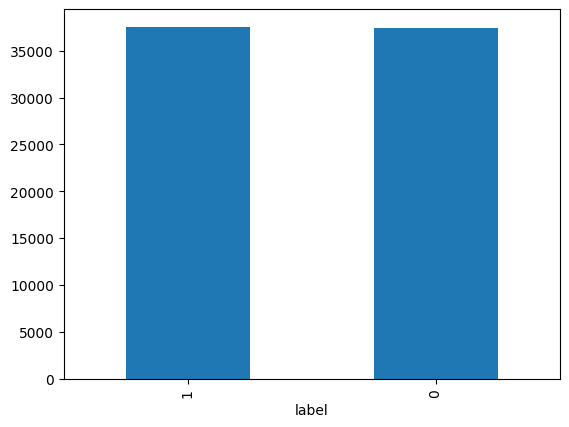

In [18]:
train_data['label'].value_counts().plot(kind='bar')

In [19]:
print(train_data.groupby('label').size().reset_index(name='count'))

   label  count
0      0  37376
1      1  37543


---

## 📌 그룹화 및 개수 세기

```python
train_data.groupby('label')
```

→ `label` 값(0, 1)으로 데이터를 그룹화

```python
train_data.groupby('label').size()
```

```
label  
0    3  ← label이 0인 데이터 3개  
1    3  ← label이 1인 데이터 3개  
dtype: int64
```

→ 각 그룹의 개수를 세기

```python
   label  count  
0      0      3  
1      1      3
```

→ 인덱스를 리셋하고 개수 열의 이름을 `'count'`로 지정

---


In [ ]:
train_data['reviews'] = train_data['reviews'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","", regex=True)


---

## 🧹 한글 이외 문자 제거 (정규표현식)

```python
train_data['reviews']  # reviews 열을 선택
.str.replace('[^ㄱ-ㅎㅏ-ㅣ가-힣 ]', '', regex=True)
```

* `.str.replace()` : 문자열 치환 메서드
* `regex=True` : 정규표현식 사용

### 🔍 정규표현식 해석: `[^ㄱ-ㅎㅏ-ㅣ가-힣 ]`

| 표현    | 의미                    |
| ----- | --------------------- |
| `^`   | NOT (부정)              |
| `ㄱ-ㅎ` | 한글 자음 (ㄱ, ㄴ, ..., ㅎ)  |
| `ㅏ-ㅣ` | 한글 모음 (ㅏ, ㅑ, ..., ㅣ)  |
| `가-힣` | 완성된 한글 (가, 나, ..., 힣) |
| 공백    | 띄어쓰기 포함               |

→ **"한글 자음, 모음, 완성형 한글, 공백이 아닌 모든 문자"를 제거**

---


In [ ]:
import numpy as np
# 테스트 데이터도 똑같이 전처리
test_data.drop_duplicates(subset = ['reviews'], inplace=True) # 중복 제거
test_data['reviews'] = test_data['reviews'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","", regex=True) # 정규 표현식 수행
test_data['reviews'].replace('', np.nan, inplace=True) # 공백은 Null 값으로 변경
test_data = test_data.dropna(how='any') # Null 값 제거
print('전처리 후 테스트용 샘플의 개수 :',len(test_data))

전처리 후 테스트용 샘플의 개수 : 24921


C:\Users\정주환\AppData\Local\Temp\ipykernel_12920\2826755773.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  test_data['reviews'].replace('', np.nan, inplace=True) # 공백은 Null 값으로 변경


In [22]:
# 불용어 정의
stopwords = ['도', '는', '다', '의', '가', '이', '은', '한', '에', '하', '고', '을', '를', '인', '듯', '과', '와', '네', '들', '듯', '지', '임', '게', '만', '게임', '겜', '되', '음', '면']


In [28]:
# 로컬환경 mecap 설치가 복잡한 이유로 mecab->Kiwi 로 형태소 분석기 변환
from kiwipiepy import Kiwi

kiwi = Kiwi()

def kiwi_tokenize(text):
   return [token.form for token in kiwi.tokenize(text)] 

train_data['tokenized'] = train_data['reviews'].apply(kiwi_tokenize)
train_data['tokenized'] = train_data['tokenized'].apply(lambda x: [item for item in x if item not in stopwords])
test_data['tokenized'] = test_data['reviews'].apply(kiwi_tokenize)
test_data['tokenized'] = test_data['tokenized'].apply(lambda x: [item for item in x if item not in stopwords])

---

## 🧱 Kiwi 토큰 객체 구조

```python
from kiwipiepy import Kiwi

kiwi = Kiwi()
tokens = kiwi.tokenize("안녕하세요 좋은 하루입니다")

for token in tokens:
    print(f"form: {token.form}")    # 형태소 표면형
    print(f"tag: {token.tag}")      # 품사 태그
    print(f"start: {token.start}")  # 시작 위치
    print(f"len: {token.len}")      # 길이
    print("---")
```

### 🧾 결과 예시

```
form: 안녕
tag: NNG
start: 0
len: 2
```

### 📌 각 속성의 의미

1. `token.form`
   → 형태소의 **표면형** (실제 나타나는 단어)

2. `token.tag`
   → **품사 태그** (예:
   `NNG`: 일반명사, `VA`: 형용사, `EP`: 선어말어미 등)

3. `token.start`
   → **원본 텍스트에서의 시작 위치**

4. `token.len`
   → **토큰의 길이**

---


---

## 🧾 토큰화 예시

| reviews     | tokenized              |
| ----------- | ---------------------- |
| 정말 좋은 영화였어요 | \[정말, 좋, 은, 영화, 였, 어요] |
| 별로 재미없네요    | \[별로, 재미, 없, 네요]       |
| 최고의 작품입니다   | \[최고, 의, 작품, 입니다]      |

→ 문장을 형태소 단위로 분해한 결과

---


In [29]:
negative_words = np.hstack(train_data[train_data.label == 0]['tokenized'].values)
positive_words = np.hstack(train_data[train_data.label == 1]['tokenized'].values)

hstack = horizontal stack  
배열들을 좌우로 이어붙입니다  
열(column) 방향으로 연결합니다  

In [30]:
from collections import Counter

negative_word_count = Counter(negative_words)
print(negative_word_count.most_common(20))


[('.', 19474), ('ᆫ', 18570), ('어', 15931), ('었', 13292), ('ᆷ', 11358), ('ᆯ', 10930), ('안', 8159), ('어서', 7631), ('것', 7305), ('없', 7162), ('거', 7024), ('나', 6424), ('는데', 5758), ('있', 5732), ('...', 5211), ('사', 5127), ('보', 5051), ('ᆸ니다', 4280), ('같', 4263), ('기', 4251)]


In [31]:
positive_word_count = Counter(positive_words)
print(positive_word_count.most_common(20))


[('.', 23660), ('ᆫ', 19599), ('어', 15326), ('었', 12675), ('ᆯ', 12181), ('있', 9957), ('ᆷ', 7451), ('것', 6894), ('ᆸ니다', 6661), ('어서', 6505), ('보', 6451), ('좋', 5839), ('습니다', 5180), ('기', 4988), ('재밌', 4982), ('나', 4977), ('거', 4949), (',', 4903), ('지만', 4549), ('없', 4160)]


most_common() 메소드는 Counter 객체에서 제공하는 메소드로, 가장 빈번하게 나타나는 요소들을 빈도 순으로 정렬해서 반환하는 기능

In [33]:
positive_len = train_data[train_data['label']==1]['tokenized'].map(lambda x:len(x))
negative_len = train_data[train_data['label']==0]['tokenized'].map(lambda x:len(x))

---

## 🔁 `map()` 함수로 토큰 개수 세기

### 1️⃣ 데이터 구조 확인

```python
train_data[train_data['label'] == 1]['tokenized']
```

예시:

```
0    ['this', 'movie', 'is', 'great', 'amazing']
1    ['wonderful', 'film', 'love', 'it']
2    ['excellent', 'acting', 'superb', 'story', 'fantastic']
...
```


### 2️⃣ `map()` 함수 동작

```python
.map(lambda x: len(x))
```

→ 각 리스트에 `len()` 함수를 적용하여 토큰 개수를 반환

예:

```
['this', 'movie', 'is', 'great', 'amazing'] → 5  
['wonderful', 'film', 'love', 'it'] → 4  
['excellent', 'acting', 'superb', 'story', 'fantastic'] → 5
```



---


In [35]:
import plotly.express as px
from plotly.subplots import make_subplots
fig = make_subplots(
    rows=1, cols=2,
    subplot_titles=('Positive Reviews', 'Negative Reviews')
)
fig1 = px.histogram(
    x = positive_len,
    color_discrete_sequence = ['red']
)
fig2 = px.histogram(
    x = negative_len,
    color_discrete_sequence = ['blue']
)

fig.add_trace(
    fig1.data[0],
    row=1,col=1
)
fig.add_trace(
    fig2.data[0],
    row=1,col=2
)

# 레이아웃 설정
fig.update_layout(
    title_text="Words in texts",
    showlegend=False,
    width=1000, height=500
)

fig.update_xaxes(title_text="length of samples")
fig.update_yaxes(title_text="number of samples")

print('긍정 리뷰의 평균 길이 :', np.mean(positive_len))
print('부정 리뷰의 평균 길이 :', np.mean(negative_len))

fig.show()

긍정 리뷰의 평균 길이 : 17.9734704205844
부정 리뷰의 평균 길이 : 18.40590218321918


In [36]:
X_train = train_data['tokenized'].values
y_train = train_data['label'].values
X_test= test_data['tokenized'].values
y_test = test_data['label'].values


In [39]:
from keras_preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences

tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

---

## 📚 `fit_on_texts()` — 단어 사전 생성

```python
from tensorflow.keras.preprocessing.text import Tokenizer

texts = [
    ['I', 'love', 'this', 'movie'],
    ['This', 'movie', 'is', 'great'],
    ['I', 'hate', 'this', 'film']
]

tokenizer = Tokenizer()
tokenizer.fit_on_texts(texts)
```


### ✅ 주요 기능

#### 1️⃣ 단어 빈도 계산

```python
tokenizer.word_counts
```

```
OrderedDict([
  ('i', 2), ('love', 1), ('this', 2), ('movie', 2),
  ('is', 1), ('great', 1), ('hate', 1), ('film', 1)
])
```

#### 2️⃣ 단어 인덱스 생성 (빈도순)

```python
tokenizer.word_index
```

```
{'i': 1, 'this': 2, 'movie': 3, 'love': 4, 'is': 5, 'great': 6, 'hate': 7, 'film': 8}
```

#### 3️⃣ 기타 통계 정보

```python
tokenizer.document_count      # 3
len(tokenizer.word_index)    # 8
```



→ **단어 사전을 기반으로 텍스트를 숫자 시퀀스로 변환**

---


In [40]:
threshold = 2
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)


단어 집합(vocabulary)의 크기 : 38929
등장 빈도가 1번 이하인 희귀 단어의 수: 20692
단어 집합에서 희귀 단어의 비율: 53.153176295306835
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 1.5184370636016136


In [41]:
# 전체 단어 개수 중 빈도수 2이하인 단어 개수는 제거.
# 0번 패딩 토큰과 1번 OOV 토큰을 고려하여 +2
vocab_size = total_cnt - rare_cnt + 2
print('단어 집합의 크기 :',vocab_size)


단어 집합의 크기 : 18239


In [42]:
tokenizer = Tokenizer(vocab_size, oov_token = 'OOV') 
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

---

## 📚 `oov_token` — 범위 밖 단어 처리

```python
from tensorflow.keras.preprocessing.text import Tokenizer

# 테스트 데이터
texts = [['hello', 'world'], ['hello', 'python'], ['world', 'coding']]

tokenizer = Tokenizer(num_words=3, oov_token='<UNK>')
tokenizer.fit_on_texts(texts)
```

### ✅ 동작 원리

#### 1️⃣ 전체 단어 사전 생성

```python
tokenizer.word_index
```

```
{
  '<UNK>': 1,    # OOV 토큰이 첫 번째
  'hello': 2,    # 빈도 1위 
  'world': 3,    # 빈도 2위
  'python': 4,   # 빈도 3위 (범위 초과!)
  'coding': 5    # 빈도 4위 (범위 초과!)
}
```

#### 2️⃣ 범위 제한 적용 (`num_words=3`)

**사용 가능한 인덱스**: 1, 2, 3
- `1`: `<UNK>` (OOV 토큰)
- `2`: `hello` 
- `3`: `world`

**범위 초과**: `python`(4), `coding`(5) → 모두 `<UNK>`로 변환

#### 3️⃣ 실제 변환 결과

```python
# 변환 전
test_text = [['hello', 'world', 'python', 'coding']]

# 변환 후
result = tokenizer.texts_to_sequences(test_text)
print(result)
```

```
[[2, 3, 1, 1]]
# hello world <UNK> <UNK>
```

### 🎯 핵심 포인트

- **`oov_token`**: 범위를 벗어나거나 없는 단어들의 **대체재**
- **자동 처리**: `num_words` 범위 초과 시 **자동으로 OOV 인덱스로 변환**
- **메모리 효율**: 상위 N개 단어만 사용해 **어휘 크기 제한**

→ **저빈도 단어들을 효율적으로 처리하는 전처리 기법**

---

---

## 📚 `texts_to_sequences()` — 텍스트를 숫자로 변환

```python
from tensorflow.keras.preprocessing.text import Tokenizer

# 1. 단어 사전 생성
texts = [['good', 'movie'], ['bad', 'film'], ['great', 'movie']]
tokenizer = Tokenizer()
tokenizer.fit_on_texts(texts)

print(tokenizer.word_index)
```

```
{'movie': 1, 'good': 2, 'bad': 3, 'film': 4, 'great': 5}
```

### ✅ 텍스트 → 숫자 시퀀스 변환

#### 1️⃣ 기본 변환

```python
# 텍스트 준비
new_texts = [['good', 'movie'], ['bad', 'film', 'terrible']]

# 숫자로 변환
sequences = tokenizer.texts_to_sequences(new_texts)
print(sequences)
```

```
[[2, 1], [3, 4]]
# good movie → [2, 1]
# bad film → [3, 4]  ('terrible'은 사전에 없어서 제외됨)
```

#### 2️⃣ OOV 토큰 있는 경우

```python
tokenizer = Tokenizer(oov_token='<UNK>')
tokenizer.fit_on_texts(texts)

new_texts = [['good', 'movie'], ['bad', 'terrible']]  # 'terrible' 없음
sequences = tokenizer.texts_to_sequences(new_texts)
print(sequences)
```

```
[[2, 1], [4, 1]]
# good movie → [2, 1] 
# bad terrible → [4, 1]  ('terrible'이 <UNK>로 변환)
```

#### 3️⃣ 범위 제한과 함께

```python
tokenizer = Tokenizer(num_words=3, oov_token='<UNK>')
tokenizer.fit_on_texts(texts)

new_texts = [['good', 'movie', 'great']]  # 'great'는 범위 초과
sequences = tokenizer.texts_to_sequences(new_texts)
print(sequences)
```

```
[[2, 3, 1]]
# good movie great → [2, 3, 1]  ('great'가 <UNK>로 변환)
```

### 🎯 핵심 기능

- **단어 → 인덱스**: 학습된 단어 사전으로 **텍스트를 숫자로 변환**
- **모델 입력 준비**: 딥러닝 모델이 이해할 수 있는 **숫자 형태로 변환**
- **일관성 유지**: 같은 토크나이저로 **train/test 데이터 동일하게 처리**

→ **자연어 처리 모델의 필수 전처리 단계**

---

In [43]:
print(X_train[:3])

[[340, 6, 48, 88, 159, 589, 270, 35, 22, 81, 64, 54, 3, 124, 16, 56, 16], [74, 142, 306, 29, 5, 72, 450, 645, 535, 9, 21, 5, 93], [4867, 1299, 15]]


In [44]:
print(X_test[:3])

[[792, 1326, 14, 426, 16, 113, 52, 17, 2362, 5, 487], [4757, 702, 427, 775, 692, 150, 15, 1643, 106, 345, 248, 6, 86, 3, 9, 7, 583, 594, 5091, 269, 186, 3803, 6, 48, 88, 445, 9, 5727, 5130], [868, 68, 33, 395]]


In [45]:
print('리뷰의 최대 길이 :',max(len(review) for review in X_train))
print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))

리뷰의 최대 길이 : 75
리뷰의 평균 길이 : 18.189204340687944


리뷰의 최대 길이는 75, 평균 길이는 약 18입니다. 전체적으로는 60이하의 길이를 가지는 것으로 보입니다.

In [ ]:
# 샘플 데이터를 trim or pad 했을 경우에 데이터 비율 계산
def below_threshold_len(max_len, nested_list):
  count = 0
  for sentence in nested_list:
    if(len(sentence) <= max_len):
        count = count + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (count / len(nested_list))*100))


In [47]:
max_len = 60
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 60 이하인 샘플의 비율: 99.86518773608832


In [48]:
X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)


In [49]:
import re
from tensorflow.keras.layers import Embedding, Dense, LSTM, Bidirectional
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

embedding_dim = 100
hidden_units = 128

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(Bidirectional(LSTM(hidden_units))) # Bidirectional LSTM을 사용
model.add(Dense(1, activation='sigmoid'))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=15, callbacks=[es, mc], batch_size=256, validation_split=0.2)


Epoch 1/15
234/235 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - acc: 0.5962 - loss: 0.6562
Epoch 1: val_acc improved from -inf to 0.75380, saving model to best_model.h5


235/235 ━━━━━━━━━━━━━━━━━━━━ 40s 159ms/step - acc: 0.5968 - loss: 0.6557 - val_acc: 0.7538 - val_loss: 0.5109
Epoch 2/15
234/235 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - acc: 0.7677 - loss: 0.4912
Epoch 2: val_acc improved from 0.75380 to 0.77930, saving model to best_model.h5


235/235 ━━━━━━━━━━━━━━━━━━━━ 41s 173ms/step - acc: 0.7678 - loss: 0.4911 - val_acc: 0.7793 - val_loss: 0.4740
Epoch 3/15
234/235 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - acc: 0.7992 - loss: 0.4435
Epoch 3: val_acc improved from 0.77930 to 0.77936, saving model to best_model.h5


235/235 ━━━━━━━━━━━━━━━━━━━━ 42s 180ms/step - acc: 0.7992 - loss: 0.4436 - val_acc: 0.7794 - val_loss: 0.4838
Epoch 4/15
234/235 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - acc: 0.8108 - loss: 0.4246
Epoch 4: val_acc improved from 0.77936 to 0.78717, saving model to best_model.h5


235/235 ━━━━━━━━━━━━━━━━━━━━ 40s 169ms/step - acc: 0.8108 - loss: 0.4246 - val_acc: 0.7872 - val_loss: 0.4626
Epoch 5/15
234/235 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - acc: 0.8202 - loss: 0.4062
Epoch 5: val_acc did not improve from 0.78717
235/235 ━━━━━━━━━━━━━━━━━━━━ 41s 173ms/step - acc: 0.8202 - loss: 0.4062 - val_acc: 0.7861 - val_loss: 0.4742
Epoch 6/15
234/235 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - acc: 0.8304 - loss: 0.3922
Epoch 6: val_acc did not improve from 0.78717
235/235 ━━━━━━━━━━━━━━━━━━━━ 43s 182ms/step - acc: 0.8304 - loss: 0.3922 - val_acc: 0.7834 - val_loss: 0.4573
Epoch 7/15
234/235 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step - acc: 0.8370 - loss: 0.3786
Epoch 7: val_acc did not improve from 0.78717
235/235 ━━━━━━━━━━━━━━━━━━━━ 47s 199ms/step - acc: 0.8370 - loss: 0.3786 - val_acc: 0.7826 - val_loss: 0.4866
Epoch 8/15
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - acc: 0.8482 - loss: 0.3595
Epoch 8: val_acc did not improve from 0.78717
235/235 ━━━━━━━━━━━━━━━━━━━━ 46s 197ms/step 

In [50]:
loaded_model = load_model('best_model.h5')
print("테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

779/779 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - acc: 0.7761 - loss: 0.4782
테스트 정확도: 0.7767


In [51]:
def sentiment_predict(new_sentence):
  new_sentence = re.sub(r'[^ㄱ-ㅎㅏ-ㅣ가-힣 ]','', new_sentence)
  new_sentence = kiwi_tokenize(new_sentence) # 토큰화
  new_sentence = [word for word in new_sentence if not word in stopwords] # 불용어 제거
  encoded = tokenizer.texts_to_sequences([new_sentence]) # 정수 인코딩
  pad_new = pad_sequences(encoded, maxlen = max_len) # 패딩
  score = float(loaded_model.predict(pad_new)) # 예측
  if(score > 0.5):
    print("{:.2f}% 확률로 긍정 리뷰입니다.".format(score * 100))
  else:
    print("{:.2f}% 확률로 부정 리뷰입니다.".format((1 - score) * 100))


In [52]:
sentiment_predict('노잼 ..완전 재미 없음 ㅉㅉ')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step
77.23% 확률로 부정 리뷰입니다.


C:\Users\정주환\AppData\Local\Temp\ipykernel_12920\840317953.py:7: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)



In [53]:
sentiment_predict('조금 어렵지만 재밌음ㅋㅋ')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
98.19% 확률로 긍정 리뷰입니다.


C:\Users\정주환\AppData\Local\Temp\ipykernel_12920\840317953.py:7: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)



In [54]:
sentiment_predict('케릭터가 예뻐서 좋아요')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
90.64% 확률로 긍정 리뷰입니다.


C:\Users\정주환\AppData\Local\Temp\ipykernel_12920\840317953.py:7: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)

